In [26]:
import os
import numpy as np
import pandas as pd
import time

#importing required libraries for spliting the data
from sklearn.model_selection import train_test_split

#importing required libraries for Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#importing required libraries for visualization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import plotly.express as px

#importing required libraries for image feature extraction
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage import exposure

In [27]:
levels = ['Normal', 'Covid']
path = 'C:/Users/TOSHEBA PC/Desktop/project'

data_dir = os.path.join(path)

data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level)):
        data.append(['{}/{}'.format(level, file), level])

data = pd.DataFrame(data, columns = ['image_file', 'corona_result'])

data['path'] = path + '/' + data['image_file']
data['corona_result'] = data['corona_result'].map({'Normal': 'Negative', 'Covid': 'Positive'})

data.head()

,image_file,corona_result,path
0,Normal/Normal-1.png,Negative,C:/Users/TOSHEBA PC/Desktop/project/Normal/Nor...
1,Normal/Normal-10.png,Negative,C:/Users/TOSHEBA PC/Desktop/project/Normal/Nor...
2,Normal/Normal-100.png,Negative,C:/Users/TOSHEBA PC/Desktop/project/Normal/Nor...
3,Normal/Normal-1000.png,Negative,C:/Users/TOSHEBA PC/Desktop/project/Normal/Nor...
4,Normal/Normal-101.png,Negative,C:/Users/TOSHEBA PC/Desktop/project/Normal/Nor...


In [19]:
all_data = []

# Storing images and their labels into a list for further Train Test split

for i in range(len(data)):
    image = cv2.imread(data['path'][i])
    label = 1 if data['corona_result'][i] == "Positive" else 0
    all_data.append([image, label])

In [20]:
x = []
y = []

for image, label in all_data:
    x.append(image)
    y.append(label)

In [22]:
def main(thresh):
    
    def CalcFeatures(img, th):
        sift = cv2.xfeatures2d.SIFT_create(th)
        kp, des = sift.detectAndCompute(img, None)
        return des
      

#     All the files appended to the image_path list are passed through the
#     CalcFeatures functions which returns the descriptors which are 
#     appended to the features list and then stacked vertically in the form
#     of a numpy array.

    
    features = []
    for img in x:
        img_des = CalcFeatures(img, thresh)
        if img_des is not None:
            features.append(img_des)
    features = np.vstack(features)
    


#   K-Means clustering is then performed on the feature array obtained 
#   from the previous step. The centres obtained after clustering are 
#   further used for bagging of features.

    k = 150
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.1)
    flags = cv2.KMEANS_RANDOM_CENTERS
    compactness, labels, centres = cv2.kmeans(features, k, None, criteria, 10, flags)

    
#   The bag_of_features function assigns the features which are similar
#   to a specific cluster centre thus forming a Bag of Words approach.  

    
    def bag_of_features(features, centres, k = 500):
        vec = np.zeros((1, k))
        for i in range(features.shape[0]):
            feat = features[i]
            diff = np.tile(feat, (k, 1)) - centres #distance calculation
            dist = pow(((pow(diff, 2)).sum(axis = 1)), 0.5)
            idx_dist = dist.argsort()
            idx = idx_dist[0]
            vec[0][idx] += 1
        return vec
    
    
    vec = []
    for img in x:
        img_des = CalcFeatures(img, thresh)
        if img_des is not None:
            img_vec = bag_of_features(img_des, centres, k)
            vec.append(img_vec)
    vec = np.vstack(vec)
    
    
    return vec

for i in range(10,26,10):
    data = main(i)

KeyboardInterrupt: 

In [7]:
#   Splitting the data formed into test and split data and training the 
#   SVM Classifier.

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2)

clf = SVC()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
acc = accuracy_score(y_test, preds)
print('Accuracy: {}'.format(acc*100))

result = []
class1 = (y_test != preds).sum()
class1 = ((len(y_test) - class1)/len(y_test)) * 100
result.append(class1)

Accuracy: 91.25


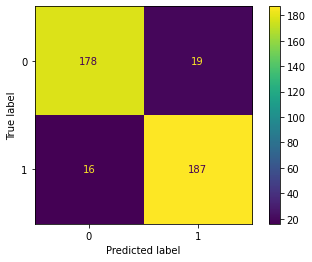

In [8]:
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

In [9]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
acc = accuracy_score(y_test, preds)
print('Accuracy: {}'.format(acc*100))

class1 = (y_test != preds).sum()
class1 = ((len(y_test) - class1)/len(y_test)) * 100
result.append(class1)

Accuracy: 81.75


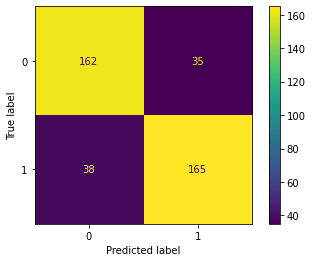

In [10]:
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

In [11]:
clf=KNeighborsClassifier()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
acc = accuracy_score(y_test, preds)
print('Accuracy: {}'.format(acc*100))

class1 = (y_test != preds).sum()
class1 = ((len(y_test) - class1)/len(y_test)) * 100
result.append(class1)

Accuracy: 84.0


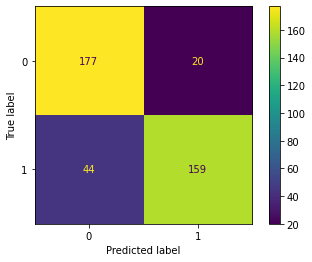

In [12]:
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

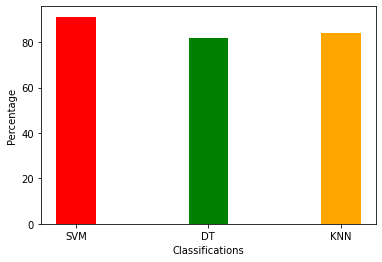

In [13]:
x = ["SVM", "DT","KNN"]
h = result
c = ["red", "green", "orange"]
plt.bar(x,h,width=0.3, color=c)
plt.xlabel("Classifications")
plt.ylabel("Percentage")
plt.show()